Date-A-Scientist

In recent years, there has been a massive rise in the usage of dating apps to find love. Many of these apps use sophisticated data science techniques to recommend possible matches to users and to optimize the user experience. These apps give us access to a wealth of information that we’ve never had before about how different people experience romance.

In this capstone, you will analyze some data from OKCupid, an app that focuses on using multiple choice and short answers to match users.

In [164]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv('profiles.csv')


In [165]:
df.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [166]:
df.age.value_counts()

26     3724
27     3685
28     3583
25     3531
29     3295
24     3242
30     3149
31     2735
23     2592
32     2587
33     2206
22     1934
34     1902
35     1755
36     1583
37     1427
38     1330
21     1282
39     1172
42     1072
40     1030
41      980
20      953
43      858
44      708
45      643
19      611
46      578
47      529
48      481
49      459
50      437
51      350
52      344
18      309
56      271
54      267
55      265
57      256
53      252
59      221
58      197
60      195
61      176
62      167
63      138
64      113
65      109
66      105
67       66
68       59
69       31
110       1
109       1
Name: age, dtype: int64

In [167]:
mean_age_straight = df.loc[df['orientation'] == 'straight']
straight = mean_age_straight.age.mean()
mean_age_straight = df.loc[df['orientation'] == 'gay']
gay = mean_age_straight.age.mean()
mean_age_straight = df.loc[df['orientation'] == 'bisexual']
bisexual = mean_age_straight.age.mean()

print('straight: ' + str(straight))
print('gay: ' + str(gay))
print('bisexual: ' + str(bisexual))
df.orientation.value_counts()

straight: 32.51437817308065
gay: 32.22860218912614
bisexual: 29.31839537405132


straight    51606
gay          5573
bisexual     2767
Name: orientation, dtype: int64

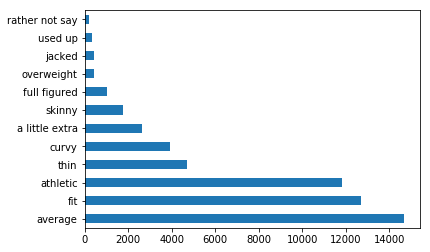

In [168]:
df['body_type'].value_counts().plot(kind='barh')

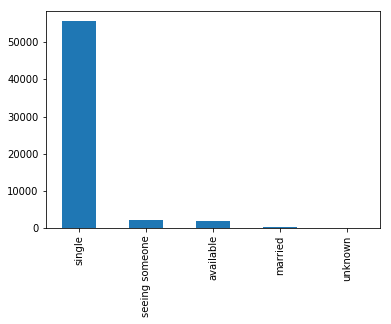

In [169]:
df['status'].value_counts().plot(kind='bar')

In [170]:
### turn diet into vegetarian/vegan and all else
diet_mapping = {"mostly kosher": 'non_veg', "mostly halal": 'non_veg', "strictly kosher": 'non_veg', "strictly halal": 'non_veg', "kosher": 'non_veg', "halal": 'non_veg',
                "mostly vegetarian": 'veg', "mostly vegan": 'veg', "strictly vegetarian": 'veg', "vegetarian": 'veg', "mostly vegan": 'veg', 
                "strictly vegan": 'veg', "vegan": 'veg', "mostly anything": 'non_veg', "anything": 'non_veg', "strictly anything": 'non_veg', "mostly other": 'non_veg', 
                "strictly other": 'non_veg', "other": 'non_veg'}
df["diet_code"] = df.diet.map(diet_mapping)

drink_mapping = {"not at all": 0, "rarely": 1, "socially": 2, "often": 3, "very often": 4, "desperately": 5}
smokes_mapping = {"no": 0, "when drinking": 1, "sometimes": 2, "trying to quit": 3, "yes": 4}
drugs_mapping = {"never": 0, "sometimes": 1, "often": 2}
df["drinks_code"] = df.drinks.map(drink_mapping)
df["smokes_code"] = df.smokes.map(smokes_mapping)
df["drugs_code"] = df.drugs.map(drugs_mapping)
df.diet_code.value_counts()

non_veg    29863
veg         5688
Name: diet_code, dtype: int64

In [171]:
essay_cols = ["essay0", "essay1", "essay2", "essay3", "essay4", "essay5", "essay6", "essay7", "essay8", "essay9"]
all_essays = df[essay_cols].replace(np.nan, '', regex=True)
all_essays = all_essays[essay_cols].apply(lambda x: ' '.join(x), axis=1)
df["essay_len"] = all_essays.apply(lambda x: len(x))
df['frequency_I_Me'] = all_essays.apply(lambda x: x.count('i') + x.count('me'))
df['frequency_veg'] = all_essays.apply(lambda x: x.count('vegetarian') + x.count('vegan'))
all_essays = all_essays.apply(lambda x: x.split())
df['average_word_length'] = all_essays.apply(lambda x: sum(len(str(word)) for word in x)/len(x) if len(x) > 0 else 0)
df.frequency_veg.value_counts()

0     56859
1      2107
2       674
3       153
4        78
5        36
6        21
7         9
8         3
11        2
9         2
12        1
10        1
Name: frequency_veg, dtype: int64

In [172]:
### first classifier to state if vegetarian/vegan or something else
model_data = df[['income', 'age', 'frequency_veg', 'smokes_code', 'drinks_code', 'drugs_code', 'height', 'essay_len', 'average_word_length', 'frequency_I_Me', 'diet_code']]
model_data.dropna(inplace=True)
diet_feature_data_KN = model_data[['income', 'age']]
#diet_feature_data = preprocessing.scale(diet_feature_data)
diet_label_data_KN = model_data['diet_code']
x = diet_feature_data_KN.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
diet_feature_data_KN = pd.DataFrame(x_scaled, columns=diet_feature_data_KN.columns)


#training_set, validation_set = train_test_split(diet_data, train_size = 0.8, test_size = 0.2, random_state = 1)
x_train, x_test, y_train, y_test = train_test_split(diet_feature_data_KN, diet_label_data_KN, train_size = 0.8, test_size = 0.2, random_state = 1)

classifierKN = KNeighborsClassifier(n_neighbors = 4)
classifierKN.fit(x_train, y_train)
print(classifierKN.score(x_test, y_test))
guessesKN = classifierKN.predict(x_test)
print(guessesKN)
labelsKN = y_test.to_numpy()
print(labelsKN)

C:\Users\ncrem\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ncrem\Miniconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


0.8469505178365938
['non_veg' 'non_veg' 'non_veg' ... 'non_veg' 'non_veg' 'non_veg']
['non_veg' 'non_veg' 'non_veg' ... 'veg' 'non_veg' 'non_veg']


In [173]:
k = range(1,15)
validation_accuracy = []
for item in k:
    classifierKN = KNeighborsClassifier(n_neighbors = item)
    classifierKN.fit(x_train, y_train)
    validation_accuracy.append(classifierKN.score(x_test, y_test))

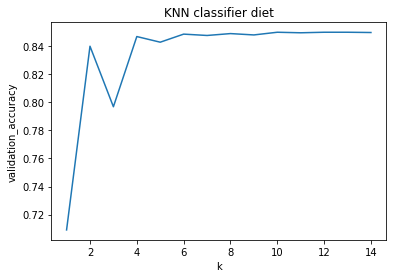

In [174]:
plt.plot(k, validation_accuracy)
plt.xlabel('k')
plt.ylabel('validation_accuracy')
plt.title('KNN classifier diet')
plt.show()

In [175]:
# validation scores
print('accuracy_score: ' + str(accuracy_score(labelsKN, guessesKN)))
print('recall_score: ' + str(recall_score(labelsKN, guessesKN, average='macro')))
print('precision_score: ' + str(precision_score(labelsKN, guessesKN, average='macro')))

### what would be the best average parameter when target is multiclass? Average = micro returned the exact same value for all accuracy, recall and precision.

accuracy_score: 0.8469505178365938
recall_score: 0.5014617493780755
precision_score: 0.5362123256860098


In [176]:
#pretty good accuracy (number of correct guesses/divided by number of total guesses), 
#recall is rather low (measures the percentage of relevant items that my classifier found)
#precision: fairly ok, it predicts the number of relevant items out of all items selected
### by including the frequency_veg variable with the "vegetarian/vegan" instead of "environment/animal", the metrics improved

In [177]:
diet_feature_data_NB = model_data[['income', 'age', 'frequency_veg']]
#diet_feature_data_NB = preprocessing.scale(diet_feature_data_NB)
x = diet_feature_data_NB.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
diet_feature_data_NB = pd.DataFrame(x_scaled, columns=diet_feature_data_NB.columns)
diet_label_data_NB = model_data['diet_code']
x_train, x_test, y_train, y_test = train_test_split(diet_feature_data_NB, diet_label_data_NB, train_size = 0.8, test_size = 0.2, random_state = 1)
classifierNB = MultinomialNB()
classifierNB.fit(x_train, y_train)
print(classifierNB.score(x_test, y_test))
guessesNB = classifierNB.predict(x_test)
labelsNB = y_test.to_numpy()

0.8498273878020713


C:\Users\ncrem\Miniconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [178]:
print('accuracy_score: ' + str(accuracy_score(labelsNB, guessesNB)))
print('recall_score: ' + str(recall_score(labelsNB, guessesNB, average='macro')))
print('precision_score: ' + str(precision_score(labelsNB, guessesNB, average='macro')))
# very poor precision: the KN classifier works better on that performance metrics, the other two are very similar

accuracy_score: 0.8498273878020713

C:\Users\ncrem\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



recall_score: 0.5
precision_score: 0.42491369390103567


In [179]:
### Regression models: predict age (Do people at the same age have some common traits?)

# Multiple Linear Regression
age_feature_data_MLR = model_data[['height', 'frequency_I_Me', 'income']]
#age_feature_data_MLR = model_data['income']
age_label_data_MLR = model_data['age']
x_train, x_test, y_train, y_test = train_test_split(age_feature_data_MLR, age_label_data_MLR, train_size = 0.8, test_size = 0.2, random_state = 1)

mlr = LinearRegression()
#x_train = x_train.values.reshape(-1, 1)
mlr.fit(x_train, y_train)
#x_test = x_test.values.reshape(-1, 1)
y_predict_MLR = mlr.predict(x_test)
print(mlr.coef_)
# I improved the model by excluding (one after the other) the feature with coefficient closest to null
print('Train score: %.5f' % mlr.score(x_train, y_train))
print('Test score: %.5f' % mlr.score(x_test, y_test))
# Score returns the coefficient of determination R² of the prediction. R² is the percentage variation in y explained by all the x variables together. My current model explains close to no variation in the y variable (age)
# The score does neither improve when just using income as the only explaining variable

[-7.74200524e-02  3.62938461e-03 -4.94558806e-07]
Train score: 0.00369
Test score: 0.00463


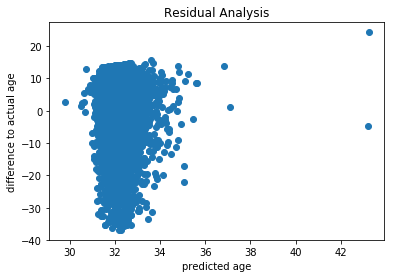

In [180]:
residuals_MLR = y_predict_MLR - y_test
plt.scatter(y_predict_MLR, residuals_MLR)
plt.title('Residual Analysis')
plt.xlabel('predicted age')
plt.ylabel('difference to actual age')
plt.show()
# it looks like my model is only predicting ages around 32, while the dataset clearly has also older people. Not a very good model

In [181]:
# KNN regressor
age_feature_data_KNN = model_data[['income', 'frequency_I_Me', 'height']]
age_label_data_KNN = model_data['age']
x_train, x_test, y_train, y_test = train_test_split(age_feature_data_MLR, age_label_data_MLR, train_size = 0.8, test_size = 0.2, random_state = 1)

regressor = KNeighborsRegressor(n_neighbors = 10, weights = 'distance')
regressor.fit(x_train, y_train)
guesses_KNN = regressor.predict(x_test)
print('Train score: %.5f' % regressor.score(x_train, y_train))
print('Test score: %.5f' % regressor.score(x_test, y_test))

# Better score: so it means that this model is better at explaining the variation in age, but still very low score. So, in general not a good model

Train score: 0.48896
Test score: -0.21889


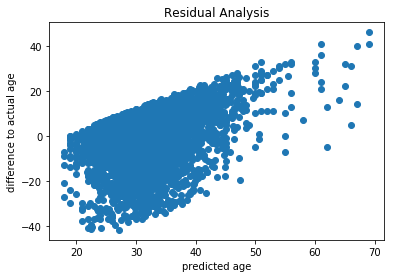

In [182]:
residuals_KNN = guesses_KNN - y_test
plt.scatter(guesses_KNN, residuals_KNN)
plt.title('Residual Analysis')
plt.xlabel('predicted age')
plt.ylabel('difference to actual age')
plt.show()
# also this model clearly underpredicts the higher age people. There must be another feature that explains better if somebody is older